In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset from the URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(url)

# Create a 'datetime' column and set it as the index
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# Fill missing 'pm2.5' values using forward-fill
df['pm2.5'].fillna(method='ffill', inplace=True)

# Drop initial rows that were NaN before filling
df = df.iloc[24:]

print("Data loaded and cleaned successfully.")
df[['pm2.5']].head()

Data loaded and cleaned successfully.


C:\Users\Purvanshu\AppData\Local\Temp\ipykernel_22112\3247061532.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pm2.5'].fillna(method='ffill', inplace=True)
C:\Users\Purvanshu\AppData\Local\Temp\ipykernel_22112\3247061532.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['pm2.5'].fillna(method='ffill', inplace=True)


,pm2.5
datetime,
2010-01-02 00:00:00,129.0
2010-01-02 01:00:00,148.0
2010-01-02 02:00:00,159.0
2010-01-02 03:00:00,181.0
2010-01-02 04:00:00,138.0


In [ ]:
# Resample the hourly data to daily data by taking the mean for each day
daily_df = df[['pm2.5']].resample('D').mean()

print("Data converted from hourly to daily averages:")
daily_df.head()

Data converted from hourly to daily averages:


,pm2.5
datetime,
2010-01-02,145.958333
2010-01-03,78.833333
2010-01-04,31.333333
2010-01-05,42.458333
2010-01-06,56.416667


In [ ]:
# Define the window sizes for our moving averages
short_window = 7   # 7 days for the short-term trend
long_window = 30  # 30 days for the long-term trend

# Calculate the moving averages and add them as new columns to our DataFrame
daily_df['short_mavg'] = daily_df['pm2.5'].rolling(window=short_window).mean()
daily_df['long_mavg'] = daily_df['pm2.5'].rolling(window=long_window).mean()

print("Moving averages calculated. Our model is ready.")
# Display the table with our new model columns (NaNs will appear at the start)
daily_df.tail()

Moving averages calculated. Our model is ready.


,pm2.5,short_mavg,long_mavg
datetime,,,
2014-12-27,238.666667,95.095238,84.747222
2014-12-28,197.375000,120.648810,88.147222
2014-12-29,159.000000,129.755952,83.395833
2014-12-30,46.083333,121.785714,81.884722
2014-12-31,10.041667,121.202381,81.718056


In [ ]:
# Create a new 'signal' column. Set it to 1 if the short average is above the long average, else 0.
daily_df['signal'] = np.where(daily_df['short_mavg'] > daily_df['long_mavg'], 1, 0)

# We can also create a column to find the exact moment of the "crossover"
# This is 1 only on the day the signal changes from Low (0) to High (1)
daily_df['crossover'] = np.where((daily_df['signal'] == 1) & (daily_df['signal'].shift(1) == 0), 1, 0)

print("Pollution signals detected.")
# Show the last few days where a crossover to high pollution was detected
daily_df[daily_df['crossover'] == 1].tail()

Pollution signals detected.


,pm2.5,short_mavg,long_mavg,signal,crossover
datetime,,,,,
2014-10-01,82.541667,75.505952,69.001389,1,1
2014-10-07,143.833333,82.303571,70.408333,1,1
2014-10-20,215.375000,136.833333,116.805556,1,1
2014-11-19,319.875000,112.529762,100.759722,1,1
2014-12-27,238.666667,95.095238,84.747222,1,1


In [ ]:


# Split the data: 80% for training, 20% for testing
split_ratio = 0.8
split_point = int(len(X) * split_ratio)

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Training set size: {len(X_train)} sequences")
print(f"Testing set size: {len(X_test)} sequences")

Training set size: 35020 sequences
Testing set size: 8756 sequences


Plotting data for the last available year: 2014


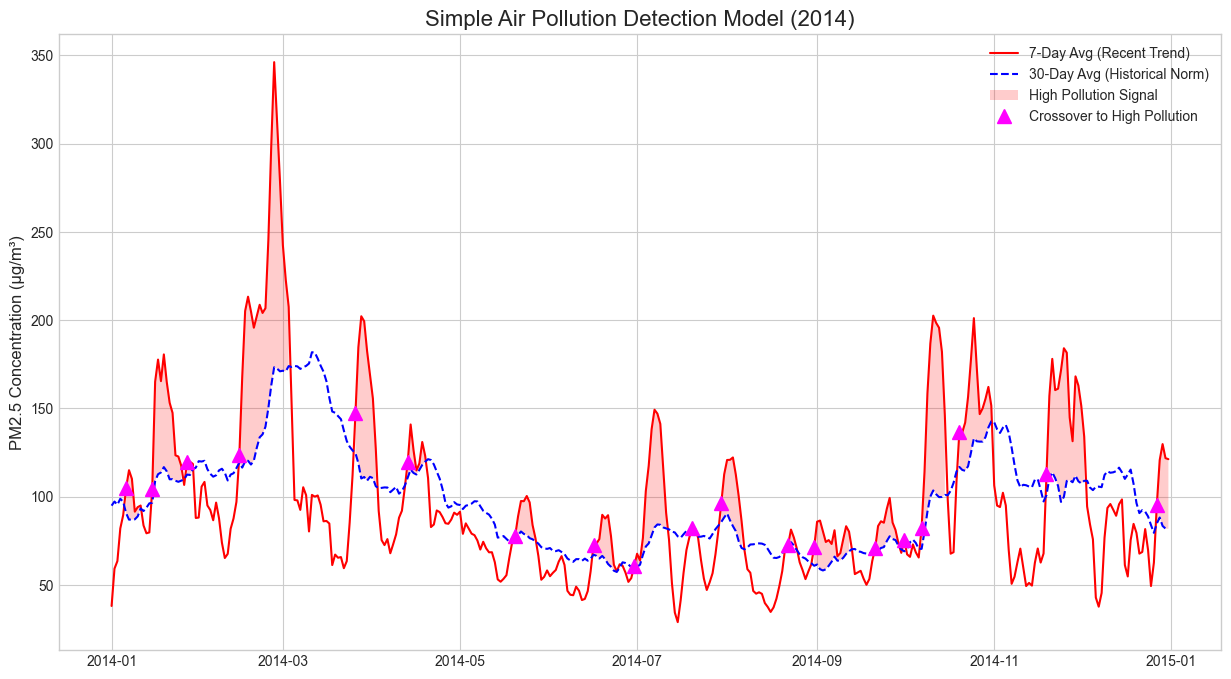

In [ ]:

# 1. Find the year of the last date in our processed data
last_year = daily_df.index.max().year

# 2. Create an explicit boolean mask to select all data from that year
# This is more robust than using a string shortcut like '2014'.
plot_df = daily_df[daily_df.index.year == last_year]

print(f"Plotting data for the last available year: {last_year}")


# --- The rest of the plotting code is the same ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 8))

# Plot the short and long moving averages
plt.plot(plot_df.index, plot_df['short_mavg'], label=f'{short_window}-Day Avg (Recent Trend)', color='red')
plt.plot(plot_df.index, plot_df['long_mavg'], label=f'{long_window}-Day Avg (Historical Norm)', color='blue', linestyle='--')

# Color the area between the lines to show the signal
plt.fill_between(plot_df.index, plot_df['short_mavg'], plot_df['long_mavg'],
                 where=(plot_df['short_mavg'] > plot_df['long_mavg']),
                 facecolor='red', alpha=0.2, label='High Pollution Signal')

# Plot the crossover points where the signal starts
plt.plot(plot_df[plot_df['crossover'] == 1].index,
         plot_df['short_mavg'][plot_df['crossover'] == 1],
         '^', markersize=10, color='magenta', label='Crossover to High Pollution')


plt.title(f'Simple Air Pollution Detection Model ({last_year})', fontsize=16)
plt.ylabel('PM2.5 Concentration (µg/m³)', fontsize=12)
plt.legend()
plt.show()